In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


In [ ]:
IMG_SIZE = (128, 128)   # smaller size for ANN (faster training)
BATCH = 32
SEED = 42

In [ ]:
!pip install medmnist tensorflow scikit-learn



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 4.1 MB/s eta 0:00:00


In [ ]:
import medmnist
from medmnist import INFO
import numpy as np

# Choose dataset
data_flag = 'pneumoniamnist'
download = True

# Get dataset info
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# Load datasets
train_dataset = DataClass(split='train', download=download, as_rgb=False)
val_dataset   = DataClass(split='val', download=download, as_rgb=False)
test_dataset  = DataClass(split='test', download=download, as_rgb=False)

# Convert to numpy
x_train, y_train = train_dataset.imgs, train_dataset.labels.ravel()
x_val, y_val     = val_dataset.imgs, val_dataset.labels.ravel()
x_test, y_test   = test_dataset.imgs, test_dataset.labels.ravel()

print("Train:", x_train.shape, y_train.shape)
print("Val:", x_val.shape, y_val.shape)
print("Test:", x_test.shape, y_test.shape)


100%|██████████| 4.17M/4.17M [00:04<00:00, 901kB/s] 

Train: (4708, 28, 28) (4708,)
Val: (524, 28, 28) (524,)
Test: (624, 28, 28) (624,)


In [ ]:
# Normalize to [0,1]
x_train = x_train.astype("float32") / 255.0
x_val   = x_val.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

# Flatten pixels for ANN
x_train_flat = x_train.reshape(len(x_train), -1)
x_val_flat   = x_val.reshape(len(x_val), -1)
x_test_flat  = x_test.reshape(len(x_test), -1)

print("Flattened input shape:", x_train_flat.shape)


Flattened input shape: (4708, 784)


In [ ]:
input_dim = x_train_flat.shape[1]

ann = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

ann.compile(optimizer=keras.optimizers.Adam(1e-3),
            loss="binary_crossentropy",
            metrics=["accuracy"])

es = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = ann.fit(x_train_flat, y_train,
                  validation_data=(x_val_flat, y_val),
                  epochs=20, batch_size=128,
                  callbacks=[es])


Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7123 - loss: 0.6319 - val_accuracy: 0.7824 - val_loss: 0.3966
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8517 - loss: 0.3656 - val_accuracy: 0.9294 - val_loss: 0.2066
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9121 - loss: 0.2226 - val_accuracy: 0.9427 - val_loss: 0.1700
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9183 - loss: 0.1913 - val_accuracy: 0.9466 - val_loss: 0.1599
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9307 - loss: 0.1699 - val_accuracy: 0.9561 - val_loss: 0.1470
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9356 - loss: 0.1629 - val_accuracy: 0.9523 - val_loss: 0.1436
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9386 - loss: 0.1576 - val_accuracy: 0.8931 - val_loss: 0.2672
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9346 - loss: 0.1772 - val_accuracy: 0.9427 - val

In [ ]:
y_prob = ann.predict(x_test_flat).ravel()
y_pred = (y_prob >= 0.5).astype(int)

print("AUC:", roc_auc_score(y_test, y_prob))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
AUC: 0.9180473372781065
[[136  98]
 [  6 384]]
              precision    recall  f1-score   support

           0     0.9577    0.5812    0.7234       234
           1     0.7967    0.9846    0.8807       390

    accuracy                         0.8333       624
   macro avg     0.8772    0.7829    0.8021       624
weighted avg     0.8571    0.8333    0.8217       624



In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# If ANN was trained on flattened vectors
x_test_ann = x_test.reshape(x_test.shape[0], -1)  # flatten into (n_samples, features)

# Now predict
y_pred_ann = ann.predict(x_test_ann)
y_pred_ann = np.argmax(y_pred_ann, axis=1)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


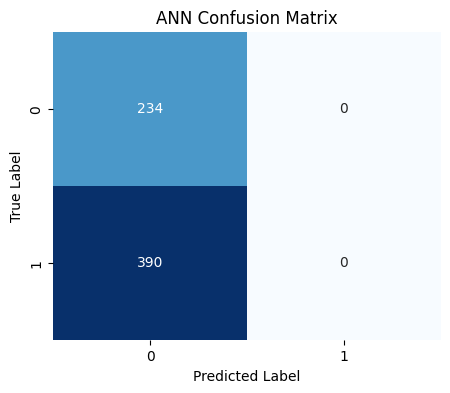

In [ ]:
cm_ann = confusion_matrix(y_test, y_pred_ann)
plt.figure(figsize=(5,4))
sns.heatmap(cm_ann, annot=True, fmt='d', cmap="Blues", cbar=False)
plt.title("ANN Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()